# ONNX to HAR

In [11]:
from hailo_sdk_client import ClientRunner

In [12]:
onnx_model_name = 'yolov8m'
onnx_path = 'best.onnx'

In [13]:
chosen_hw_arch = 'hailo8'

In [14]:
runner = ClientRunner(hw_arch=chosen_hw_arch)

# Adjusting the end node names as per HailoRT's requirements
end_node_names = [
    '/0/model.22/cv2.0/cv2.0.2/Conv',
    '/0/model.22/cv3.0/cv3.0.2/Conv',
    '/0/model.22/cv2.1/cv2.1.2/Conv',
    '/0/model.22/cv3.1/cv3.1.2/Conv',
    '/0/model.22/cv2.2/cv2.2.2/Conv',
    '/0/model.22/cv3.2/cv3.2.2/Conv'
]

hn, npz = runner.translate_onnx_model(
    onnx_path,
    onnx_model_name,
    start_node_names=['input'],
    end_node_names=end_node_names,
    net_input_shapes={'input': [1, 3, 640, 640]}
)

[info] Translation started on ONNX model yolov8m
[info] Restored ONNX model yolov8m (completion time: 00:00:00.19)
[info] Extracted ONNXRuntime meta-data for Hailo model (completion time: 00:00:01.03)
[info] NMS structure of yolov8 (or equivalent architecture) was detected.
[info] In order to use HailoRT post-processing capabilities, these end node names should be used: /0/model.22/cv2.0/cv2.0.2/Conv /0/model.22/cv3.0/cv3.0.2/Conv /0/model.22/cv2.1/cv2.1.2/Conv /0/model.22/cv3.1/cv3.1.2/Conv /0/model.22/cv2.2/cv2.2.2/Conv /0/model.22/cv3.2/cv3.2.2/Conv.
[info] Start nodes mapped from original model: 'input': 'yolov8m/input_layer1'.
[info] End nodes mapped from original model: '/0/model.22/cv2.0/cv2.0.2/Conv', '/0/model.22/cv3.0/cv3.0.2/Conv', '/0/model.22/cv2.1/cv2.1.2/Conv', '/0/model.22/cv3.1/cv3.1.2/Conv', '/0/model.22/cv2.2/cv2.2.2/Conv', '/0/model.22/cv3.2/cv3.2.2/Conv'.
[info] Translation completed on ONNX model yolov8m (completion time: 00:00:01.78)


# Save Parsed Model

In [15]:
hailo_model_har_name = f'{onnx_model_name}_hailo_model.har'
runner.save_har(hailo_model_har_name)

[info] Saved HAR to: /home/inventec/Documents/hailo_convert/yolov8m_hailo_model.har


[info] Current Time: 12:34:15, 06/26/24
[info] CPU: Architecture: x86_64, Model: Intel(R) Core(TM) i7-14700K, Number Of Cores: 28, Utilization: 0.2%
[info] Memory: Total: 62GB, Available: 48GB
[info] System info: OS: Linux, Kernel: 6.5.0-41-generic
[info] Hailo DFC Version: 3.27.0
[info] HailoRT Version: 4.17.0
[info] PCIe: No Hailo PCIe device was found
[info] Running `hailo visualizer yolov8m_hailo_model.har --no-browser`


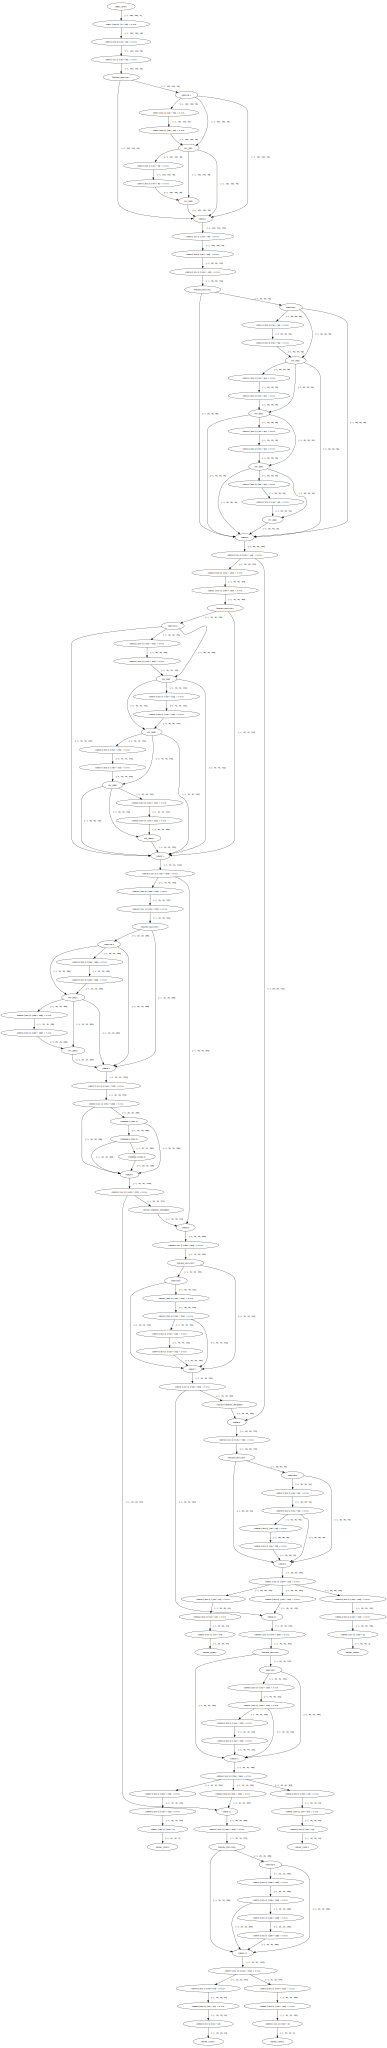

In [16]:
from IPython.display import SVG

!hailo visualizer {hailo_model_har_name} --no-browser
SVG('yolov8m.svg')

# Quick Model Optimization

In [17]:
# importing everything needed
from hailo_sdk_client import ClientRunner, InferenceContext

import json
import os

import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
from IPython.display import SVG
from matplotlib import pyplot as plt
from PIL import Image

IMAGES_TO_VISUALIZE = 5

In [18]:
# First, we will prepare the calibration set. Resize the images to the correct size and crop them.
from tensorflow.python.eager.context import eager_mode


def preproc(image, output_height=640, output_width=640, resize_side=640):
    ''' imagenet-standard: aspect-preserving resize to 256px smaller-side, then central-crop to 224px'''
    with eager_mode():
        h, w = image.shape[0], image.shape[1]
        scale = tf.cond(tf.less(h, w), lambda: resize_side / h, lambda: resize_side / w)
        resized_image = tf.compat.v1.image.resize_bilinear(tf.expand_dims(image, 0), [int(h*scale), int(w*scale)])
        cropped_image = tf.compat.v1.image.resize_with_crop_or_pad(resized_image, output_height, output_width)

        return tf.squeeze(cropped_image)


images_path = '../Pill_Dataset/valid/images'
images_list = [img_name for img_name in os.listdir(images_path) if
               os.path.splitext(img_name)[1] == '.jpg']

calib_dataset = np.zeros((len(images_list), 640, 640, 3))
for idx, img_name in enumerate(sorted(images_list)):
    img = np.array(Image.open(os.path.join(images_path, img_name)))
    img_preproc = preproc(img)
    calib_dataset[idx, :, :, :] = img_preproc.numpy()

np.save('calib_set.npy', calib_dataset)



In [19]:
# Second, we will load our parsed HAR from the Parsing Tutorial

model_name = 'yolov8m'
hailo_model_har_name = f'{model_name}_hailo_model.har'
assert os.path.isfile(hailo_model_har_name), 'Please provide valid path for HAR file'
runner = ClientRunner(har=hailo_model_har_name)
# By default it uses the hw_arch that is saved on the HAR. For overriding, use the hw_arch flag.

In [20]:
# Now we will create a model script, that tells the compiler to add a normalization on the beginning
# of the model (that is why we didn't normalize the calibration set;
# Otherwise we would have to normalize it before using it)

# Batch size is 8 by default
alls = "alls/yolov8m.alls"
       

# Load the model script to ClientRunner so it will be considered on optimization
runner.load_model_script(alls)

# Call Optimize to perform the optimization process
runner.optimize(calib_dataset)

# Save the result state to a Quantized HAR file
quantized_model_har_path = f'{model_name}_quantized_model.har'
runner.save_har(quantized_model_har_path)

[info] Loading model script commands to yolov8m from alls/yolov8m.alls
[info] The layer yolov8m/conv57 was detected as reg_layer.
[info] The layer yolov8m/conv70 was detected as reg_layer.
[info] The layer yolov8m/conv82 was detected as reg_layer.
[info] Starting Model Optimization
[warning] Reducing optimization level to 0 (the accuracy won't be optimized and compression won't be used) because there's no available GPU
[info] Model received quantization params from the hn
[info] Starting Mixed Precision
[info] Mixed Precision is done (completion time is 00:00:00.05)
[info] create_layer_norm skipped
[info] Starting Stats Collector
[info] Using dataset with 64 entries for calibration


Calibration: 100%|█████████████████████████| 64/64 [00:26<00:00,  2.39entries/s]


[info] Stats Collector is done (completion time is 00:00:27.65)
[info] Bias Correction skipped
[info] Adaround skipped
[info] Starting Fine Tune
[warning] Dataset is larger than expected size. Increasing the algorithm dataset size might improve the results
[info] Using dataset with 1024 entries for finetune
Epoch 1/4
512/512 [==============================] - 987s 2s/step - total_distill_loss: 18.0709 - _distill_loss_yolov8m/conv57: 0.2890 - _distill_loss_yolov8m/conv58: 3.1724 - _distill_loss_yolov8m/conv70: 0.2569 - _distill_loss_yolov8m/conv71: 5.6752 - _distill_loss_yolov8m/conv82: 0.1338 - _distill_loss_yolov8m/conv83: 7.4840 - _distill_loss_yolov8m/conv64: 0.4365 - _distill_loss_yolov8m/conv51: 0.3186 - _distill_loss_yolov8m/conv77: 0.3046
Epoch 2/4
512/512 [==============================] - 948s 2s/step - total_distill_loss: 140.1912 - _distill_loss_yolov8m/conv57: 0.3678 - _distill_loss_yolov8m/conv58: 1.0125 - _distill_loss_yolov8m/conv70: 0.3286 - _distill_loss_yolov8m/conv71

# Compilation 

In [21]:
from hailo_sdk_client import ClientRunner

In [22]:
model_name = 'yolov8m'
quantized_model_har_path = f'{model_name}_quantized_model.har'

In [23]:
runner = ClientRunner(har=quantized_model_har_path)
# By default it uses the hw_arch that is saved on the HAR. It is not recommended to change the hw_arch after Optimization.

In [24]:
hef = runner.compile()

file_name = f'{model_name}.hef'
with open(file_name, 'wb') as f:
    f.write(hef)

[info] Adding an output layer after conv57
[info] Adding an output layer after conv58
[info] Adding an output layer after conv70
[info] Adding an output layer after conv71
[info] Adding an output layer after conv82
[info] Adding an output layer after conv83
[info] Loading network parameters
[warning] Output order different size
[info] Starting Hailo allocation and compilation flow
[info] Finding the best partition to contexts...
[info] Iteration #1 - Contexts: 2
[info] Iteration #2 - Contexts: 2
[info] Iteration #3 - Contexts: 2
[info] Iteration #4 - Contexts: 2
[info] Iteration #5 - Contexts: 2
[info] Iteration #6 - Contexts: 2
[info] Iteration #7 - Contexts: 2
[info] Iteration #8 - Contexts: 2
[info] Iteration #9 - Contexts: 2
[info] Iteration #10 - Contexts: 2
[info] Iteration #11 - Contexts: 2
[info] Iteration #12 - Contexts: 3
[info] Iteration #13 - Contexts: 3
[info] Iteration #14 - Contexts: 3
[info] Iteration #15 - Contexts: 3
[info] Iteration #16 - Contexts: 3
[info] Iteration



[info] Context:0/0 Iteration 0: Mapping prepost...          
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1                                                                                                  
 worker2                                                                                                  
 worker3                                                                                                  

  00:00
[info] Context:0/3 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1                                                                                                  
 worker2   

[info] Context:0/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  V          *          V          V          V          V          V          V          V       
 worker1  *          *          V          V          V          V          V          V          V       
 worker2  *          *          *          *          *          *          *          *          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:01
[info] Context:0/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  V          *          V          V          V          V          V          V          V       
 worker1  *          *          V          V          V          V          V          V          V       
 worker2  *  

[info] Context:1/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  *          *          *          *          *          *          *          *          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:06
[info] Context:1/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          V          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  *  

[info] Context:2/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  V          *          V          *          V          V          V          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  *          *          *          *          *          *          *          *          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:11
[info] Context:2/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  V          *          V          *          V          V          V          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  *  

[info] Context:2/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  V          *          V          V          V          V          V          V          V       
 worker1  *          V          V          *          V          V          *          X          V       
 worker2  *          V          V          V          V          V          V          V          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:12
[info] Context:2/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  V          *          V          V          V          V          V          V          V       
 worker1  V          V          V          *          V          V          *          X          V       
 worker2  *  

[info] Context:3/3 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1  V          *          V          V          *          V          *          V          V       
 worker2  *          V          V          V          V          V          *          *          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:20
[info] Context:3/3 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1  V          *          V          V          *          V          *          V          V       
 worker2  *  

[info] Compiling context_1...
[info] Compiling context_2...
[info] Compiling context_3...
[info] Bandwidth of model inputs: 9.375 Mbps, outputs: 4.22974 Mbps (for a single frame)
[info] Bandwidth of DDR buffers: 0.0 Mbps (for a single frame)
[info] Bandwidth of inter context tensors: 66.7969 Mbps (for a single frame)
[info] Building HEF...
[info] Successful Compilation (compilation time: 29s)
